In [264]:
import pandas as pd


df = pd.read_json('volunteers.json')

print(df.head())


                volunteerID volunteerType                      skills  \
0  67d4c5dca1f55e61aa451467   independent     [Cooking, Organization]   
1  67d4c5e1a1f55e61aa45146a   independent  [Cleaning, Transportation]   
2  67d4c5e4a1f55e61aa45146d   independent      [Shopping, Decorating]   
3  67d4c5e8a1f55e61aa451470   independent     [Organization, Cooking]   
4  67d4c5f7a1f55e61aa451474   independent  [Transportation, Cleaning]   

                              coordinates  
0  [36.70901855428611, 3.035187264594328]  
1   [36.7032681700125, 3.062822889022711]  
2  [36.79008200929335, 3.055245863225224]  
3   [36.7587619603616, 3.030851620410438]  
4  [36.75407606788928, 3.068509714610707]  


In [265]:
# List all possible skills in your dataset
skills_list = ["Cooking", "Organization", "Cleaning", "Transportation", "Decorating", "Shopping"]

# One-hot encode the skills for each volunteer
for skill in skills_list:
    df[skill] = df['skills'].apply(lambda x: 1 if skill in x else 0)

# Check the updated dataframe
print(df.head())


                volunteerID volunteerType                      skills  \
0  67d4c5dca1f55e61aa451467   independent     [Cooking, Organization]   
1  67d4c5e1a1f55e61aa45146a   independent  [Cleaning, Transportation]   
2  67d4c5e4a1f55e61aa45146d   independent      [Shopping, Decorating]   
3  67d4c5e8a1f55e61aa451470   independent     [Organization, Cooking]   
4  67d4c5f7a1f55e61aa451474   independent  [Transportation, Cleaning]   

                              coordinates  Cooking  Organization  Cleaning  \
0  [36.70901855428611, 3.035187264594328]        1             1         0   
1   [36.7032681700125, 3.062822889022711]        0             0         1   
2  [36.79008200929335, 3.055245863225224]        0             0         0   
3   [36.7587619603616, 3.030851620410438]        1             1         0   
4  [36.75407606788928, 3.068509714610707]        0             0         1   

   Transportation  Decorating  Shopping  
0               0           0         0  
1       

In [266]:
import pandas as pd
import json
from sklearn.cluster import KMeans




initial_clusters = 15
kmeans = KMeans(n_clusters=initial_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)


In [267]:



def distribute_volunteers(df, clusters):
    teams = []
    group_number = 1  # To label each team with a number

    while len(df) > 0:  # Continue until all volunteers are assigned
        cluster_groups = df.groupby('cluster')  # Group by clusters
        cluster_dict = {cluster: group for cluster, group in cluster_groups}

        team = []
        empty_clusters = set()  # Track empty clusters

        # Loop through each cluster and pick one volunteer (if available)
        for cluster, group in cluster_dict.items():
            if len(group) > 0:
                selected_volunteer = group.iloc[0]
                team.append(selected_volunteer)
                df = df.drop(selected_volunteer.name)  # Remove from df
            else:
                empty_clusters.add(cluster)

        if team:
            group_data = {"group_name": f"Group {group_number}", "volunteers": []}
            for volunteer in team:
                group_data["volunteers"].append({
                    "volunteerID": volunteer['volunteerID'],
                    "skills": volunteer['skills'],
                    "cluster": int(volunteer['cluster'])
                })
            teams.append(group_data)
            group_number += 1

        # If any clusters are empty, re-run clustering with remaining data
        if empty_clusters and len(df) > 0:
            new_clusters = max(2, len(df) // 5)  # Adjust cluster count dynamically
            kmeans = KMeans(n_clusters=new_clusters, random_state=42)
            df['cluster'] = kmeans.fit_predict(df.drop(columns=['cluster'], errors='ignore'))

    return teams

# Run the distribution function
teams = distribute_volunteers(df, initial_clusters)

# Save the teams to JSON
with open('volunteer_teams.json', 'w') as f:
    json.dump(teams, f, indent=4)

print("Balanced volunteer teams have been written to volunteer_teams.json")

Balanced volunteer teams have been written to volunteer_teams.json


In [268]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Load your data
df1 = pd.read_json("volunteers.json")

# List all possible skills in your dataset
skills_list = ["Cooking", "Organization", "Cleaning", "Transportation", "Decorating", "Shopping"]

# One-hot encode the skills for each volunteer
for skill in skills_list:
    df1[skill] = df1['skills'].apply(lambda x: 1 if skill in x else 0)

# Drop non-numeric columns (Ensure only numerical values are used)
df1 = df1.drop(columns=["skills", "volunteerID"], errors="ignore")

# Ensure all data is numeric
df1 = df1.select_dtypes(include=["number"])



# Apply K-Means clustering
kmeans = KMeans(n_clusters=initial_clusters, random_state=42)
df1["cluster"] = kmeans.fit_predict(df1)






In [269]:
# ✅ **1. Compute Precision (Silhouette Score)**
silhouette = silhouette_score(df1.drop(columns=["cluster"]), df1["cluster"])
print(f"📊 Silhouette Score: {silhouette}")

# ✅ **2. Check Cluster Sizes**
print("📊 Cluster Sizes:")
print(df1["cluster"].value_counts())

# ✅ **3. Compute Inertia (WCSS)**
inertia = kmeans.inertia_
print(f"📊 Inertia (WCSS): {inertia}")

# ✅ **4. Compute Average Distance from Centroid**
def avg_distance_from_centroid(X, model):
    labels = model.labels_
    centroids = model.cluster_centers_
    total_distance = 0
    for i, centroid in enumerate(centroids):
        total_distance += np.sum(np.linalg.norm(X[labels == i] - centroid, axis=1))
    return total_distance / len(X)

X = df1.drop(columns=["cluster"]).values  # Convert to NumPy array
avg_distance = avg_distance_from_centroid(X, kmeans)
print(f"📊 Avg Distance from Centroid: {avg_distance}")

📊 Silhouette Score: 0.5938085920235069
📊 Cluster Sizes:
cluster
5     11
3     11
2      9
6      8
4      8
7      7
0      7
1      7
11     5
8      4
9      4
12     4
10     3
13     2
14     2
Name: count, dtype: int64
📊 Inertia (WCSS): 19.667604617604617
📊 Avg Distance from Centroid: 0.3410317907302404


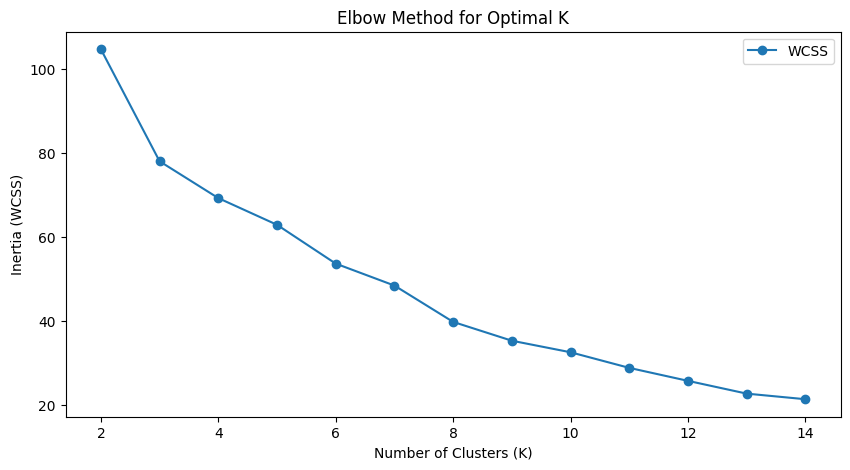

In [270]:

# ✅ **5. Compare Different K Values using Elbow Method**
wcss = []
silhouette_scores = []
K_range = range(2, initial_clusters)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans_temp.fit_predict(X)
    wcss.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(X, clusters))

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(K_range, wcss, marker='o', linestyle='-', label='WCSS')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.legend()
plt.show()

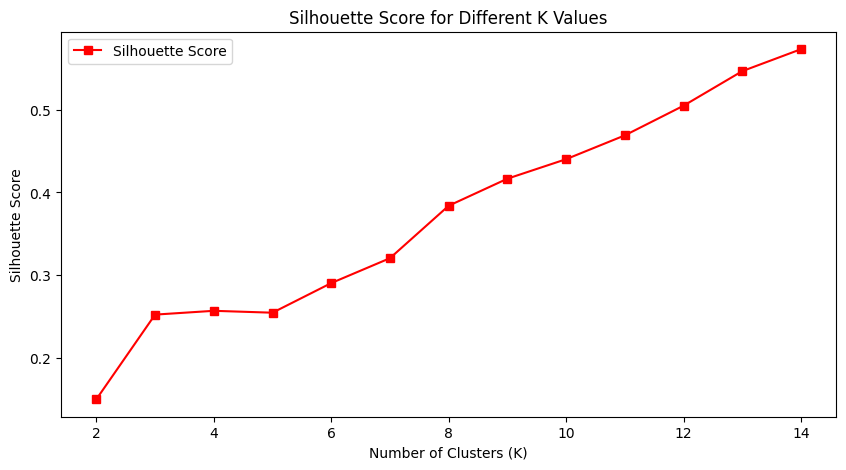

In [271]:

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, marker='s', linestyle='-', color='r', label='Silhouette Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different K Values')
plt.legend()
plt.show()

In [272]:
import pandas as pd
import json
import math
from collections import defaultdict

# Load Data
volunteers = pd.read_json("volunteers.json")
locations = pd.read_json("locations.json")

with open("volunteer_teams.json", "r") as f:
    volunteer_teams = json.load(f)

# Convert volunteer teams into a dictionary (volunteerID -> associationId)
volunteer_associations = {}
for team in volunteer_teams:
    for volunteer in team["volunteers"]:
        volunteer_associations[volunteer["volunteerID"]] = team["group_name"]

# Extract latitude & longitude
volunteers["latitude"] = volunteers["coordinates"].apply(lambda x: x[0])
volunteers["longitude"] = volunteers["coordinates"].apply(lambda x: x[1])

locations["latitude"] = locations["coordinates"].apply(lambda x: x[0])
locations["longitude"] = locations["coordinates"].apply(lambda x: x[1])


assigned_volunteers = defaultdict(int)


def haversine_distance(coord1, coord2):
    R = 6371  # Earth radius in KM
    lat1, lon1 = map(math.radians, coord1)
    lat2, lon2 = map(math.radians, coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

matches_by_volunteer = {}

for _, vol in volunteers.iterrows():
    volunteer_id = vol["volunteerID"]
    volunteer_matches = []

    for _, loc in locations.iterrows():
        location_id = loc["locationId"]
        max_allowed_volunteers = loc["requiredVolunteers"] + 5


        if assigned_volunteers[location_id] >= max_allowed_volunteers:
            continue  # Skip this location

        distance = haversine_distance((vol["latitude"], vol["longitude"]), (loc["latitude"], loc["longitude"]))

        # Find skill matches
        skill_match = list(set(vol["skills"]) & set(loc["skills"]))


        if skill_match:
            volunteer_matches.append({
                "volunteerID": volunteer_id,
                "locationId": location_id,
                "associationId": loc["associationId"],
                "distance_km": round(distance, 2),
                "skills_matched": skill_match
            })


    top_matches = sorted(volunteer_matches, key=lambda x: x["distance_km"])[:4]


    final_matches = []
    for match in top_matches:
        location_id = match["locationId"]
        if assigned_volunteers[location_id] < max_allowed_volunteers:
            final_matches.append(match)
            assigned_volunteers[location_id] += 1

    matches_by_volunteer[volunteer_id] = final_matches

matches = [match for match_list in matches_by_volunteer.values() for match in match_list]

with open("matched_volunteers.json", "w") as f:
    json.dump(matches, f, indent=4)

print("✅ Volunteer assignments saved to matched_volunteers.json (top 3-4 offers per volunteer, max limit enforced)")


✅ Volunteer assignments saved to matched_volunteers.json (top 3-4 offers per volunteer, max limit enforced)


In [273]:
import json


with open("matched_volunteers.json", "r") as f:
    matches = json.load(f)


grouped_matches = {}

for match in matches:
    volunteer_id = match["volunteerID"]

    if volunteer_id not in grouped_matches:
        grouped_matches[volunteer_id] = []

    grouped_matches[volunteer_id].append({
        "locationId": match["locationId"],
        "associationId": match["associationId"],
        "distance_km": match["distance_km"],
        "skills_matched": match["skills_matched"]
    })

with open("grouped_volunteers.json", "w") as f:
    json.dump(grouped_matches, f, indent=4)


total_volunteers = len(grouped_matches)
print(f"✅ Data grouped by volunteer ID and saved to grouped_volunteers.json")
print(f"👥 Total unique volunteers matched: {total_volunteers}")


print("\n📊 Match distribution per volunteer:")
for volunteer_id, locations in grouped_matches.items():
    print(f"- Volunteer {volunteer_id} matched with {len(locations)} locations")


✅ Data grouped by volunteer ID and saved to grouped_volunteers.json
👥 Total unique volunteers matched: 24

📊 Match distribution per volunteer:
- Volunteer 67d4c5dca1f55e61aa451467 matched with 4 locations
- Volunteer 67d4c5e1a1f55e61aa45146a matched with 4 locations
- Volunteer 67d4c5e4a1f55e61aa45146d matched with 4 locations
- Volunteer 67d4c5e8a1f55e61aa451470 matched with 4 locations
- Volunteer 67d4c5f7a1f55e61aa451474 matched with 4 locations
- Volunteer 67d4c5fba1f55e61aa451477 matched with 3 locations
- Volunteer 67d4c5ffa1f55e61aa45147a matched with 3 locations
- Volunteer 67d4c602a1f55e61aa45147d matched with 4 locations
- Volunteer 67d4c605a1f55e61aa451480 matched with 4 locations
- Volunteer 67d4c609a1f55e61aa451483 matched with 3 locations
- Volunteer 67d4cfe0a1f55e61aa451508 matched with 3 locations
- Volunteer 67d4cffca1f55e61aa45150b matched with 2 locations
- Volunteer 67d4d026a1f55e61aa45150e matched with 4 locations
- Volunteer 67d4d17bb46b32a5dc4167c3 matched with 4